This notebook takes in a list of galaxies and the voids found using $V^2$ and VoidFinder and appends to the list of galaxies columns that denote which are void, wall, edge, and outside the survey for each algorithm.  It also appends to the file the normalized depth within a V$^2$ void (calculated using Dahlia's C++ code).

In [1]:
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const

from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder.vflag import determine_vflag
from vast.voidfinder.voidfinder import ra_dec_to_xyz

import numpy as np

import pickle

from sklearn import neighbors

import matplotlib.pyplot as plt
%matplotlib inline

#### Miscellaneous functions

In [2]:
def flatten(array): # when np.flatten() doesn't work
    temp = []
    for sublist in array:
        for item in sublist:
            temp.append(item)
    return np.array(temp)

In [3]:
def rmv(array, out): # removing galaxies in "out" from galaxies in "array"
    '''
    test_out =[] 
    for i in array:
        if i in out:
            test_out.append(False)
        else:
            test_out.append(True)
    '''
    test_out = np.ones(len(array), dtype=bool)
    
    for i,obj in enumerate(array):
        if obj in out:
            test_out[i] = False
    
    return array[test_out]

# Galaxies

In [4]:
#gal_filename = 'data_all.txt'
#data = Table.read('data_all.txt', format='ascii')

gal_filename = '../../../../data/nsa_v1_0_1_VAGC.fits'

hdu = fits.open(gal_filename)
data = Table(hdu[1].data)
hdu.close()

In [5]:
data[:5]

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY [7],SERSIC_NMGY_IVAR [7],SERSIC_OK,SERSIC_RNMGY [7],SERSIC_ABSMAG [7],SERSIC_AMIVAR [7],EXTINCTION [7],SERSIC_KCORRECT [7],SERSIC_KCOEFF [5],SERSIC_MTOL [7],SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF [7],"PROFMEAN [15,7]","PROFMEAN_IVAR [15,7]","QSTOKES [15,7]","USTOKES [15,7]","BASTOKES [15,7]","PHISTOKES [15,7]",PETRO_FLUX [7],PETRO_FLUX_IVAR [7],FIBER_FLUX [7],FIBER_FLUX_IVAR [7],PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX [7],SERSIC_FLUX_IVAR [7],SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY [7],CLUMPY [7],DFLAGS [7],AID,PID,DVERSION,PROFTHETA [15],PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX [7],ELPETRO_FLUX_IVAR [7],ELPETRO_TH50 [7],ELPETRO_TH90 [7],ELPETRO_APCORR_R,ELPETRO_APCORR [7],ELPETRO_APCORR_SELF [7],ELPETRO_NMGY [7],ELPETRO_NMGY_IVAR [7],ELPETRO_OK,ELPETRO_RNMGY [7],ELPETRO_ABSMAG [7],ELPETRO_AMIVAR [7],ELPETRO_KCORRECT [7],ELPETRO_KCOEFF [5],ELPETRO_MASS,ELPETRO_MTOL [7],ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS,u_r,g_r,NUV_r,index,imc,aimc,cd,conx1,u_r_KIAS,prmag,BPTclass,SFR,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,N12logNH,NHerr,logNO,NOerr,Ne12logNeH,NeHerr,logNeO,NeOerr,Z_N2O2,vorvol
str19,str27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,str7,float32,int16,uint8,int16,str3,float32,float32,int32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,str8,float32,float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,str6,str27,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J094651.40-010228.5,09h/m00/J094651.40-010228.5,146.714215072841,-1.0412800233313741,0,72212,37354,-1,-1,-1,15.178774,0.021222278,sdss,0.07,756,1,206,301,136.2967,1095.152,0,0.020687785,29.696056 .. 3267.6895,0.29814342 .. 0.00012172792,1,31.368013 .. 3501.2527,-15.17281 .. -20.302134,223.03555 .. 1102.6129,0.4536473 .. 0.080934174,-0.005893635 .. 0.019576037,0.00017777947 .. 5.1533486e-11,0.00020792194 .. 0.98780394,2.7473723e-05,0.31195974,0.035135116,8898397000.0,215.39407348632812,213.4535369873047,10 .. 12,0.3149959 .. 0.0,233.37904 .. 0.0,0.062215745 .. -0.07950058,0.0006146176 .. -0.1274703,0.8828513 .. 0.7387829,0.2829979 .. -60.97547,18.203371 .. 2264.6604,1.9946122 .. 0.015697604,1.0260131 .. 561.97687,47.3397 .. 0.33574256,0.88909996,14.777527,0.80408496,17.367554,19.554192 .. 3146.785,1.0691423 .. 0.017162137,4.7761517,0.6651653,15.97821,-0.0109440535 .. 0.004525926,0.042470127 .. 0.042621203,0 .. 0,0,36,v2_1_13,0.22341923 .. 258.39,7.2478933,3.4641922,10.453795,5.882104,266,1,51630,146.71420341874853,-1.0412749124036818,0.0,sdss,legacy,good,122,146.71421,-1.0413043,0.80408496,17.367554,1144.0713,0.4582725,7.3913364,3.7061903,10.666219,7.3913364,18.787916 .. 2225.009,1.8480047 .. 0.017611798,5.8557696 .. 3.4004514,11.650886 .. 10.1460905,0.9986329,1.0687045 .. 1.001099,1.0695114 .. 1.0010818,28.532349 .. 2310.4973,0.42499655 .. 0.00024172392,1,28.661283 .. 2337.7668,-15.124495 .. -19.915525,293.50247 .. 10

## $V^2$ void depths

In [6]:
depth_filename = '../../../data/SDSS/NSA_depths_norm_full.txt'

V2_depths = Table.read(depth_filename, format='ascii.commented_header')

V2_depths[:5]

IAUNAME,DEPTH
str19,float64
J094651.40-010228.5,-1.0
J094630.85-004554.5,-1.0
J094631.59-005917.7,-1.0
J094744.18-004013.4,-1.0
J094751.74-003242.0,-1.0


In [7]:
np.sum(V2_depths['DEPTH'] >= 0)

248688

In [8]:
# Remove all objects without depths
V2_depths = V2_depths[V2_depths['DEPTH'] >=0]

print(len(V2_depths))

V2_depths[:5]

248688


IAUNAME,DEPTH
str19,float64
J094859.52-000208.5,0.17723137140274048
J094625.93+000251.6,0.1781003326177597
J094552.53-000534.1,0.0747702419757843
J094523.29+000431.4,0.10036593675613403
J094425.32-001707.5,0.9334629774093628


# $V^2$ classification

In [9]:
#galzones_filename = 'DR7_galzones.dat'
#zonevoids_filename = 'DR7_zonevoids.dat'

V2_gal_filename = '../../../void_catalogs/public/v1.1.0/V2_nsa_v1_0_1_gal.txt'
galzones_filename = '../../../void_catalogs/public/v1.1.0/V2_VIDE-nsa_v1_0_1_galzones.dat'
zonevoids_filename = '../../../void_catalogs/public/v1.1.0/V2_VIDE-nsa_v1_0_1_zonevoids.dat'

V2_gals = Table.read(V2_gal_filename, format='ascii.commented_header')
#galzones_old = Table.read('old_data/old/DR7_galzones.dat', format = 'ascii')
galzones = Table.read(galzones_filename, format='ascii.commented_header') 
zonevoids = Table.read(zonevoids_filename, format='ascii.commented_header')

total_glx = len(galzones)

In [10]:
V2_gals[:5]

gal,ra,dec,redshift,rabsmag
int64,float64,float64,float64,float64
0,146.6285851269414,-0.7651620976591762,0.0646563172340393,-19.97649574279785
1,146.9341288729797,-0.6704053610430766,0.12127048522233963,-21.559162139892578
2,146.9634997327016,-0.5447758299302171,0.055980585515499115,-19.10099220275879
3,146.96352370262414,-0.7593404235056136,0.09708637744188309,-20.089942932128906
4,146.85984630722874,-0.8089065016506019,0.12658987939357758,-21.062517166137695


In [11]:
galzones[:5]

gal,zone,depth,edge,out
int64,int64,int64,int64,int64
3,1036,0,1,0
7,1036,0,1,0
10,433,3,0,0
12,1036,0,1,0
13,1036,0,1,0


In [12]:
zonevoids[:5]

zone,void0,void1
int64,int64,int64
0,-1,-1
1,-1,-1
2,-1,-1
3,96,96
4,-1,-1


In [13]:
#gal_indx = galzones_old['gal']
gal_indx = galzones['gal']

In [14]:
print(total_glx)

194125


In [15]:
print(len(V2_gals), len(data))

514587 641409


So we need to determine which galaxies from the input galaxy catalog remain in the volume-limited catalog to figure out the $V^2$ classification.  Ugh...

**Note (2/15/2022):** This is now obsolete, as we reran $V^2$ on the NSA after generating an index column.

##### Identify objects in the volume-limited catalog, and add their index number to a column in `galzones`

In [16]:
'''
vollim_boolean = (V2_gals['redshift'] <= 0.114) & (V2_gals['rabsmag'] <= -20.0)

vollim_V2_gals = V2_gals[vollim_boolean]

print(len(vollim_V2_gals))
''';

In [17]:
data_coords = SkyCoord(ra=data['RA']*u.degree, 
                       dec=data['DEC']*u.degree, 
                       radial_velocity=const.c*data['Z'])
V2_coords = SkyCoord(ra=V2_gals['ra']*u.degree, 
                     dec=V2_gals['dec']*u.degree, 
                     radial_velocity=const.c*V2_gals['redshift'])

idx, d2d, d3d = V2_coords.match_to_catalog_3d(data_coords)

In [18]:
np.all(np.isclose(d3d,0))

True

## Add $V^2$ void depths

In [19]:
'''
V2_gals['depth'] = -1.

# We can cheat - the galaxy's index number is the same as its row number in V2_gals
V2_gals['depth'][V2_depths['GAL_ID']] = V2_depths['DEPTH']
''';

In [20]:
data_dict = {}

for i in range(len(data)):
    
    key = data['IAUNAME'][i]
    
    data_dict[key] = i

In [21]:
data['V2_depth'] = -1.

for i in range(len(V2_depths)):
    
    j = data_dict[V2_depths['IAUNAME'][i]]
    
    data['V2_depth'][j] = V2_depths['DEPTH'][i]

In [22]:
np.sum(data['V2_depth'] >= 0)

248688

#### Edge and outside galaxies

In [23]:
'''
edge_bool = [bool(x) for x in np.array(np.array(galzones['edge']))] 
edge_gal = np.array(gal_indx[edge_bool])
'''
edge_gal = galzones['gal'][galzones['edge'].astype(bool)]
# edge_gal is a list of the row indices in V2_gals that are edge galaxies.

print('V2 has', len(edge_gal), 'galaxies at the edge.')

edge_gal[:5]

V2 has 12981 galaxies at the edge.


3
7
12
13
15


In [24]:
'''
out_bool = [bool(x) for x in np.array(np.array(galzones['out']))]
out_gal = np.array(gal_indx[out_bool])
'''
out_gal = galzones['gal'][galzones['out'].astype(bool)]
# out_gal is a list of the row indices in V2_gals that are outside the survey.

print('V2 has', len(out_gal), 'galaxies outside.')

V2 has 0 galaxies outside.


#### Void galaxies

In [25]:
# zones that are in voids
void_zones = zonevoids['zone'][(zonevoids['void0'] != -1) & (zonevoids['void1'] != -1)]

print('V2 has', len(void_zones), 'zones that are in voids.')

V2 has 555 zones that are in voids.


In [26]:
# Make a list of all the galaxies that are in each of the zones that are part of a void
void_gal_ = []

for i in void_zones:
    void_gal_.append(list(galzones['gal'][galzones['zone'] == i]))

void_gal_flat = flatten(void_gal_) # around 200,000 are void galaxies <-- updated to 125,062

print('V2 has', len(void_gal_flat), 'galaxies that are part of a zone that is in a void.')

V2 has 125062 galaxies that are part of a zone that is in a void.


#### Fact #1: edge and outside galaxies exist in zones that are in voids

These need to therefore be removed from the list of void galaxies.

In [27]:
void_gal = rmv(void_gal_flat, edge_gal) # eliminating edge galaxies, True for non edge, about 8000

print('V2 has', len(void_gal), 'galaxies that are in voids but not along the edge of the survey.')

V2 has 125062 galaxies that are in voids but not along the edge of the survey.


In [28]:
void_gal = rmv(void_gal, out_gal)

print('V2 has', len(void_gal), 'galaxies that are in voids but not outside the survey.')

V2 has 125062 galaxies that are in voids but not outside the survey.


#### wall galaxies

In [29]:
non_void_zones = zonevoids['zone'][(zonevoids['void0'] == -1)] # zones that are not in voids

non_void_gal = []

for i in non_void_zones:
    non_void_gal.append(list(galzones['gal'][galzones['zone'] == i]))
    
print('V2 has', len(flatten(non_void_gal)), 'wall galaxies.')
        
wall_gal = rmv(flatten(non_void_gal), edge_gal)

print('V2 has', len(wall_gal), 'wall galaxies that are not on the edge.')

wall_gal = rmv(wall_gal, out_gal)

print('V2 has', len(wall_gal), 'wall galaxies that are not outside.')

V2 has 69063 wall galaxies.
V2 has 56082 wall galaxies that are not on the edge.
V2 has 56082 wall galaxies that are not outside.


### Check

In [30]:
len(wall_gal) + len(void_gal) + len(edge_gal) + len(out_gal), total_glx

(194125, 194125)

### Add vflag column to main footprint array

In [31]:
V2_gals['vflag_V2'] = -9

V2_gals['vflag_V2'][wall_gal] = 0
V2_gals['vflag_V2'][void_gal] = 1
V2_gals['vflag_V2'][edge_gal] = 2
V2_gals['vflag_V2'][out_gal] = 9

In [32]:
V2_gals[:5]

gal,ra,dec,redshift,rabsmag,vflag_V2
int64,float64,float64,float64,float64,int64
0,146.6285851269414,-0.7651620976591762,0.0646563172340393,-19.97649574279785,-9
1,146.9341288729797,-0.6704053610430766,0.12127048522233963,-21.559162139892578,-9
2,146.9634997327016,-0.5447758299302171,0.055980585515499115,-19.10099220275879,-9
3,146.96352370262414,-0.7593404235056136,0.09708637744188309,-20.089942932128906,2
4,146.85984630722874,-0.8089065016506019,0.12658987939357758,-21.062517166137695,-9


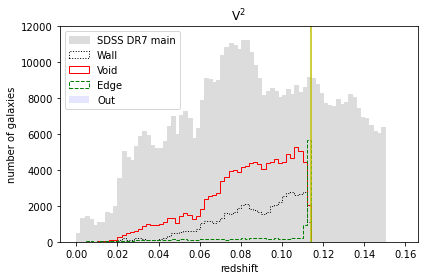

In [33]:
plt.figure(tight_layout=True)

z_bins = np.arange(0,0.16,0.002)

plt.hist(V2_gals['redshift'], bins=z_bins, color='gainsboro', ec='gainsboro', label='SDSS DR7 main')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 0], 
         bins=z_bins, histtype='step', linestyle='dotted', color='k', label='Wall')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 1], 
         bins=z_bins, histtype='step', color='r', label='Void')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 2], 
         bins=z_bins, histtype='step', color='g', linestyle='dashed', label='Edge')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 9], 
         bins=z_bins, color='b', alpha=0.1, label='Out')

plt.vlines(0.114, 0, 30000, colors='y')

plt.ylim(0,12000)

plt.xlabel('redshift')
plt.ylabel('number of galaxies')

plt.title('V$^2$')

plt.legend();

For objects that are within the same volume as the volume-limited sample, but are not part of the volume-limited sample, they get the classification of their nearest neighbor that is in the volume-limited catalog.

**Note**: We need to match via Cartesian coordinates, since we want to find which Voronoi cell each galaxy lives in, and these are defined in Carteisan space (not redshift space).

In [34]:
missing_bool = (V2_gals['vflag_V2'] == -9) & (V2_gals['redshift'] <= 0.114)

'''
missing_gal_coords = SkyCoord(ra=V2_gals['ra'][missing_bool]*u.degree, 
                              dec=V2_gals['dec'][missing_bool]*u.degree, 
                              radial_velocity=const.c*V2_gals['redshift'][missing_bool])

vollim_coords = SkyCoord(ra=V2_gals['ra'][V2_gals['vflag_V2'] != -9]*u.degree, 
                         dec=V2_gals['dec'][V2_gals['vflag_V2'] != -9]*u.degree, 
                         radial_velocity=const.c*V2_gals['redshift'][V2_gals['vflag_V2'] != -9])

idx_V2gals,_,_ = missing_gal_coords.match_to_catalog_3d(vollim_coords)
''';

V2_gals['Rgal'] = z_to_comoving_dist(V2_gals['redshift'].data.astype(np.float32), 0.315, 1)

missing_gal_xyz = ra_dec_to_xyz(V2_gals[missing_bool])
vollim_xyz = ra_dec_to_xyz(V2_gals[V2_gals['vflag_V2'] != -9])

vollim_tree = neighbors.KDTree(vollim_xyz)

_, idx_V2gals = vollim_tree.query(missing_gal_xyz) # Find the nearest galaxy

V2_gals['vflag_V2'][missing_bool] = V2_gals['vflag_V2'][V2_gals['vflag_V2'] != -9][idx_V2gals[:,0]]

V2_gals['vflag_V2'][V2_gals['vflag_V2'] == -9] = 9

In [35]:
V2_gals[:5]

gal,ra,dec,redshift,rabsmag,vflag_V2,Rgal
int64,float64,float64,float64,float64,int64,float32
0,146.6285851269414,-0.7651620976591762,0.0646563172340393,-19.97649574279785,2,190.83966
1,146.9341288729797,-0.6704053610430766,0.12127048522233963,-21.559162139892578,9,352.93777
2,146.9634997327016,-0.5447758299302171,0.055980585515499115,-19.10099220275879,2,165.5835
3,146.96352370262414,-0.7593404235056136,0.09708637744188309,-20.089942932128906,2,284.2718
4,146.85984630722874,-0.8089065016506019,0.12658987939357758,-21.062517166137695,9,367.9248


### Add vflag column to main data sample

Objects that are not in the main footprint are assigned a `vflag` value corresponding to out (9).

In [36]:
data['vflag_V2'] = 9

data['vflag_V2'][idx] = V2_gals['vflag_V2']

In [45]:
print('Galaxies with a depth:', np.sum(data['V2_depth'] >= 0))
print('Galaxies in a void:', np.sum(data['vflag_V2'] == 1))
print('Galaxies in voids with a depth:', np.sum((data['vflag_V2'] == 1) & (data['V2_depth'] >= 0)))

data[['IAUNAME', 'Z']][(data['vflag_V2'] == 1) & (data['V2_depth'] < 0)].pprint()
data['ELPETRO_ABSMAG'][(data['vflag_V2'] == 1) & (data['V2_depth'] < 0), 4].pprint()

Galaxies with a depth: 248688
Galaxies in a void: 247281
Galaxies in voids with a depth: 247278
      IAUNAME            Z     
------------------- -----------
J120529.76+615247.5 0.050744027
J120354.94+544627.5  0.04959112
J124825.36+541205.0 0.016435266
ELPETRO_ABSMAG
--------------
    -18.821424
    -19.370274
    -18.307816


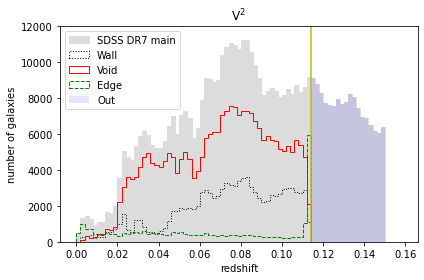

In [39]:
plt.figure(tight_layout=True)

z_bins = np.arange(0,0.16,0.002)

plt.hist(V2_gals['redshift'], bins=z_bins, color='gainsboro', ec='gainsboro', label='SDSS DR7 main')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 0], 
         bins=z_bins, histtype='step', linestyle='dotted', color='k', label='Wall')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 1], 
         bins=z_bins, histtype='step', color='r', label='Void')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 2], 
         bins=z_bins, histtype='step', color='g', linestyle='dashed', label='Edge')
plt.hist(V2_gals['redshift'][V2_gals['vflag_V2'] == 9], 
         bins=z_bins, color='b', alpha=0.1, label='Out')

plt.vlines(0.114, 0, 30000, colors='y')

plt.ylim(0,12000)

plt.xlabel('redshift')
plt.ylabel('number of galaxies')

plt.title('V$^2$')

plt.legend();

# VoidFinder classification

In [39]:
'''
data_voidfinder = Table.read('ALL_vflag_comoving.txt', format='ascii')

wall_gal_vf = np.argwhere(np.array(data_voidfinder['vflag']) == 0)
void_gal_vf = np.argwhere(np.array(data_voidfinder['vflag']) == 1)

out_gal_vf = np.argwhere(np.array(data_voidfinder['vflag']) == 9)
edge_gal_vf = np.argwhere(np.array(data_voidfinder['vflag']) == 2)
''';

In [41]:
VF_holes_filename = '../../../void_catalogs/public/v1.0.0/VoidFinder-nsa_v1_0_1_main_comoving_holes.txt'

VF_holes = Table.read(VF_holes_filename, format='ascii.commented_header')

In [42]:
mask_filename = '../../../void_catalogs/SDSS/VoidFinder/python_implementation/NSA_main_mask.pickle'

mask_infile = open(mask_filename, 'rb')
mask, mask_resolution = pickle.load(mask_infile)
mask_infile.close()

##### Convert galaxy (ra, dec, z) to (x, y, z)

In [43]:
DtoR = np.pi/180.

s = z_to_comoving_dist(data['Z'].data.astype(np.float32), 0.315, 1)

x = s*np.cos(data['DEC']*DtoR)*np.cos(data['RA']*DtoR)
y = s*np.cos(data['DEC']*DtoR)*np.sin(data['RA']*DtoR)
z = s*np.sin(data['DEC']*DtoR)

In [44]:
z_max = np.array([0.114], dtype=np.float32)

r_max = z_to_comoving_dist(z_max, 0.315, 1)

### Add vflag column to main data array

In [45]:
data['vflag_VF'] = 9

for i in range(len(data)):
    data['vflag_VF'][i] = determine_vflag(x[i], y[i], z[i], VF_holes, mask, mask_resolution, 0, r_max)

In [46]:
data[:5]

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY [7],SERSIC_NMGY_IVAR [7],SERSIC_OK,SERSIC_RNMGY [7],SERSIC_ABSMAG [7],SERSIC_AMIVAR [7],EXTINCTION [7],SERSIC_KCORRECT [7],SERSIC_KCOEFF [5],SERSIC_MTOL [7],SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF [7],"PROFMEAN [15,7]","PROFMEAN_IVAR [15,7]","QSTOKES [15,7]","USTOKES [15,7]","BASTOKES [15,7]","PHISTOKES [15,7]",PETRO_FLUX [7],PETRO_FLUX_IVAR [7],FIBER_FLUX [7],FIBER_FLUX_IVAR [7],PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX [7],SERSIC_FLUX_IVAR [7],SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY [7],CLUMPY [7],DFLAGS [7],AID,PID,DVERSION,PROFTHETA [15],PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX [7],ELPETRO_FLUX_IVAR [7],ELPETRO_TH50 [7],ELPETRO_TH90 [7],ELPETRO_APCORR_R,ELPETRO_APCORR [7],ELPETRO_APCORR_SELF [7],ELPETRO_NMGY [7],ELPETRO_NMGY_IVAR [7],ELPETRO_OK,ELPETRO_RNMGY [7],ELPETRO_ABSMAG [7],ELPETRO_AMIVAR [7],ELPETRO_KCORRECT [7],ELPETRO_KCOEFF [5],ELPETRO_MASS,ELPETRO_MTOL [7],ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS,u_r,g_r,NUV_r,index,imc,aimc,cd,conx1,u_r_KIAS,prmag,BPTclass,SFR,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,N12logNH,NHerr,logNO,NOerr,Ne12logNeH,NeHerr,logNeO,NeOerr,Z_N2O2,vorvol,vflag_V2,vflag_VF
str19,str27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,str7,float32,int16,uint8,int16,str3,float32,float32,int32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,str8,float32,float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,str6,str27,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
J094651.40-010228.5,09h/m00/J094651.40-010228.5,146.714215072841,-1.0412800233313741,0,72212,37354,-1,-1,-1,15.178774,0.021222278,sdss,0.07,756,1,206,301,136.2967,1095.152,0,0.020687785,29.696056 .. 3267.6895,0.29814342 .. 0.00012172792,1,31.368013 .. 3501.2527,-15.17281 .. -20.302134,223.03555 .. 1102.6129,0.4536473 .. 0.080934174,-0.005893635 .. 0.019576037,0.00017777947 .. 5.1533486e-11,0.00020792194 .. 0.98780394,2.7473723e-05,0.31195974,0.035135116,8898397000.0,215.39407348632812,213.4535369873047,10 .. 12,0.3149959 .. 0.0,233.37904 .. 0.0,0.062215745 .. -0.07950058,0.0006146176 .. -0.1274703,0.8828513 .. 0.7387829,0.2829979 .. -60.97547,18.203371 .. 2264.6604,1.9946122 .. 0.015697604,1.0260131 .. 561.97687,47.3397 .. 0.33574256,0.88909996,14.777527,0.80408496,17.367554,19.554192 .. 3146.785,1.0691423 .. 0.017162137,4.7761517,0.6651653,15.97821,-0.0109440535 .. 0.004525926,0.042470127 .. 0.042621203,0 .. 0,0,36,v2_1_13,0.22341923 .. 258.39,7.2478933,3.4641922,10.453795,5.882104,266,1,51630,146.71420341874853,-1.0412749124036818,0.0,sdss,legacy,good,122,146.71421,-1.0413043,0.80408496,17.367554,1144.0713,0.4582725,7.3913364,3.7061903,10.666219,7.3913364,18.787916 .. 2225.009,1.8480047 .. 0.017611798,5.8557696 .. 3.4004514,11.650886 .. 10.1460905,0.9986329,1.0687045 .. 1.001099,1.0695114 .. 1.0010818,28.532349 .. 2310.4973,0.42499655 .. 0.00024172392,1,28.661283 .. 2337.7668,-15.124495

### Check

In [42]:
#len(out_gal_vf)+len(edge_gal_vf)+len(wall_gal_vf)+len(void_gal_vf) == len(data_voidfinder)

### add flag columns and save file

In [44]:
'''
flag_vsquared=[] # checks all galaxies in each statement as a double check for any overlaps
for i in range(len(data)):
    if i in wall_gal:
        flag_vsquared.append(0)
    if i in void_gal:
        flag_vsquared.append(1)
    if i in edge_gal:
        flag_vsquared.append(2)
    if i in out_gal:
        flag_vsquared.append(9)
    
# flag_vsquared_vf=[]
# for i in range(len(data)):
#     if i in wall_gal_vf:
#         flag_vsquared_vf.append(0)
#     if i in void_gal_vf:
#         flag_vsquared_vf.append(1)
#     if i in edge_gal_vf:
#         flag_vsquared_vf.append(2)
#     if i in out_gal_vf:
#         flag_vsquared_vf.append(9)
        
print(len(flag_vsquared),len(flag_vsquared_vf), len(data)) #check
''';

In [47]:
'''
flags_table = Table([flag_vsquared_vf,flag_vsquared], names=('flag_voidfinder', 'flag_vsquared'))

data.add_columns(flags_table.columns.values())

ascii.write(data, 'data_flags_updated_Nov1.dat')
'''
data.write('../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits', format='fits', overwrite=True)